In [1]:
TRAIN = 1

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

### Data set characteristics

In [3]:
# path = 'Data/'
# img_w = 256
# img_h = 256

path = ''
# img_w = 512
# img_w = 424
img_w = 256
img_h = 256

n_labels = 2

kernel = 3

# n_train = 6
# n_test = 3

# n_train = 40110
# n_test = 17190

n_train = 5000
n_test = 2000

# n_train = 700
# n_test = 30

### Utility functions

In [4]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return label_map

In [5]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
#         img, gt = [imread(path + item[0])], np.clip(imread(path + item[1]), 0, 1)
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))],  resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

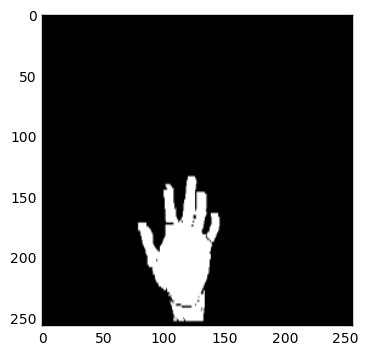

In [6]:
fn = 'E:/fingerpaint_dataset_segnet/data/labels/combinedSubjectC_labels/combinedSubjectC_labels_0004.png'
# fn = 'E:/fingerpaint_dataset_segnet/data/depth/combinedSubjectC_depth/combinedSubjectC_depth_0004.png'

img = resize(np.clip(~(imread(fn)[:, :, 0]), 0, 1), (img_h, img_w))
plt.imshow(img, cmap='gray')
plt.show()

label = []
label.append(label_map(img))

In [7]:
def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1]), 0, 1))

    plt.figure(figsize=(15, 2 * n_test))
    for i, item in df.iterrows():
        if i > 3:
            break
        plt.subplot(n_test, 5, 5 * i + 1)
        plt.title('Input Image')
        plt.axis('off')
#         im = imread(path + item[0])
        im = resize(imread(path + item[0]), (img_h, img_w))
        plt.imshow(im, cmap='gray')
        
        plt.subplot(n_test, 5, 5 * i + 2)
        plt.title('Ground Truth')
        plt.axis('off')
#         gt = imread(path + item[1])
        gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        plt.imshow(np.clip(gt, 0, 1), cmap='gray')

        plt.subplot(n_test, 5, 5 * i + 3)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled, cmap='gray')

        plt.subplot(n_test, 5, 5 * i + 4)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 5, 5 * i + 5)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        rgb[:, :, 0] = labeled
        img = resize(imread(path + item[0]), (img_h, img_w))
        rgb[:, :, 1] = img
        rgb[:, :, 2] = gt
        plt.imshow(rgb)

    plt.savefig('result.png')
    plt.show()

### Build Model

In [8]:
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)
    
# print(autoencoder.summary())

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
# autoencoder.add(Dropout(0.5))
autoencoder.add(Activation('softmax'))

with open('model_5l.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

### Loading and compiling model built with *'build_model.py'*

In [9]:
# with open('model_5l.json', 'r') as f:
#     json_string = f.read()
# autoencoder = model_from_json(json_string)

# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('Compiled: OK')

Compiled: OK


### Train model or load existing weights

In [10]:
train_data, train_label = prep_data('train')
test_data, test_label = prep_data('test')

nb_epoch = 20
batch_size = 8

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

history = autoencoder.fit(train_data, train_label,
                          batch_size=batch_size, epochs=nb_epoch,
                          verbose=1,
                          validation_data=(test_data, test_label),
                          callbacks=[early_stopping])

autoencoder.save_weights('model_5l_weight_ep50.hdf5')

train: OK==================>] 100%
	shapes: (700, 256, 256, 1), (700, 65536, 2)
	types:  float64, float64
	memory: 350.0, 700.0 MB
test: OK==================>] 100%
	shapes: (30, 256, 256, 1), (30, 65536, 2)
	types:  float64, float64
	memory: 15.0, 30.0 MB
Train on 700 samples, validate on 30 samples
Epoch 1/1000
700/700 [==============================] - 71s - loss: 0.2563 - acc: 0.9150 - val_loss: 0.4797 - val_acc: 0.7333
Epoch 2/1000
700/700 [==============================] - 58s - loss: 0.2089 - acc: 0.9301 - val_loss: 0.5943 - val_acc: 0.5999
Epoch 3/1000
700/700 [==============================] - 58s - loss: 0.1830 - acc: 0.9418 - val_loss: 0.6091 - val_acc: 0.5580
Epoch 4/1000
700/700 [==============================] - 58s - loss: 0.1553 - acc: 0.9549 - val_loss: 0.6946 - val_acc: 0.6142
Epoch 5/1000
700/700 [==============================] - 58s - loss: 0.1363 - acc: 0.9621 - val_loss: 0.6901 - val_acc: 0.5997
Epoch 6/1000
700/700 [==============================] - 58s - loss: 

KeyboardInterrupt: 

In [11]:
# plt.imshow(train_data[0, :, :, 0], cmap='gray')
# plt.show()

In [17]:
autoencoder.save_weights('model_5l_weight_ep50.hdf5')
# autoencoder.load_weights('model_5l_weight_ep50.hdf5')

### Model visualization

In [13]:
plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [14]:
test_data, test_label = prep_data('test')
score = autoencoder.evaluate(test_data, test_label, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

train_data, train_label = prep_data('train')
score = autoencoder.evaluate(train_data, train_label, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

test: OK==================>] 100%
	shapes: (30, 256, 256, 1), (30, 65536, 2)
	types:  float64, float64
	memory: 15.0, 30.0 MB
Test score: 0.0342763662338
Test accuracy: 0.98800432682
train: OK==================>] 100%
	shapes: (700, 256, 256, 1), (700, 65536, 2)
	types:  float64, float64
	memory: 350.0, 700.0 MB
Train score: 0.0294348640314
Train accuracy: 0.990282967091


### Visualizing results

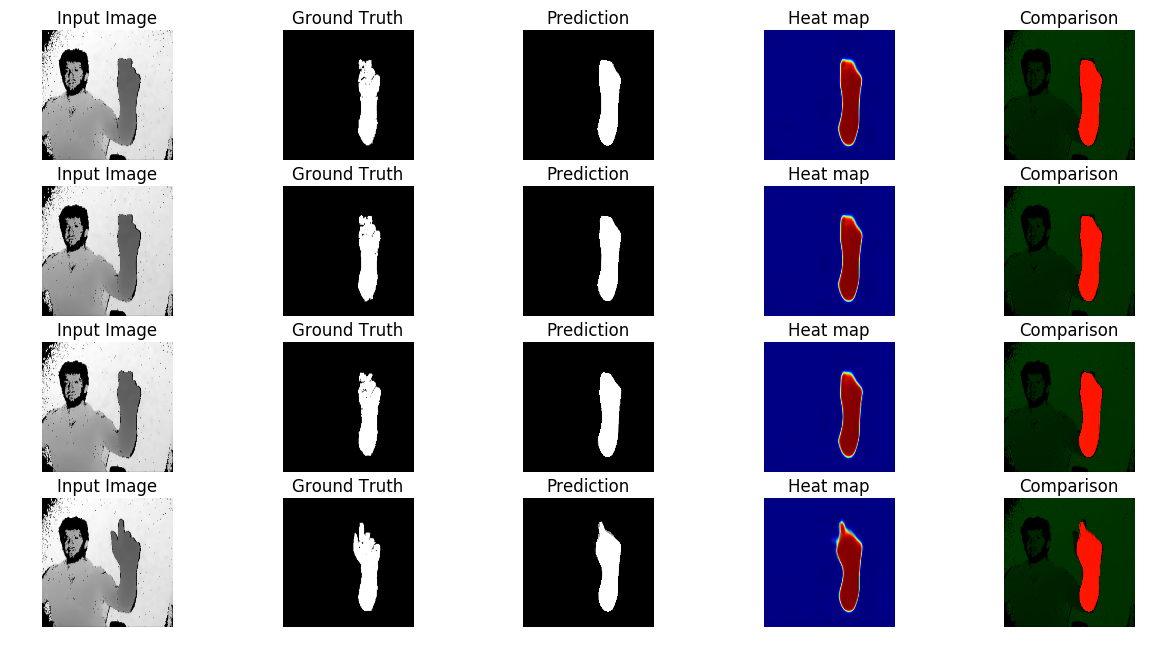

In [18]:
output = autoencoder.predict_proba(test_data, verbose=0)
# output = autoencoder.predict_proba(train_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output)

In [16]:
with open('training_his.pickle', 'wb') as f:
    pickle.dump(history.history, f)
history_ = history.history

# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined